# Brain Tumor Detector

## Get and Load Dataset

In [1]:
#!pip install --upgrade --no-cache-dir gdown

In [2]:
#!gdown --id 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=f21c8e8d-62d4-45f4-862a-d5687ef468a4
To: /home/steph/Documents/Learning/Constructor/code/brain-project/challenge/notebooks/brain_tumor.zip
100%|████████████████████████████████████████| 156M/156M [00:05<00:00, 29.6MB/s]


In [3]:
#!unzip -q brain_tumor.zip

In [4]:
#ls -l

total 182196
-rw-rw-r-- 1 steph steph   9927520 Apr  4 14:47 brain_tumor_classifier_aug_1.h5
-rw-rw-r-- 1 steph steph   9927520 Apr  4 14:49 brain_tumor_classifier_aug_2.h5
-rw-rw-r-- 1 steph steph   9927520 Apr  4 14:54 brain_tumor_classifier.h5
-rw-rw-r-- 1 steph steph    967087 Apr  4 14:48 Brain_Tumor_Detector_Helper_SK.ipynb
-rw-rw-r-- 1 steph steph 155791278 Apr  4 14:55 brain_tumor.zip
-rw-rw-r-- 1 steph steph       859 Apr  4 14:31 notes.ipynb
-rw-rw-r-- 1 steph steph      7925 Dez  7  2021 template_notebook.ipynb
drwxrwxr-x 6 steph steph      4096 Apr  4 14:55 Testing/
drwxrwxr-x 6 steph steph      4096 Apr  4 14:55 Training/


In [5]:
#!sudo apt-get install tree #just to see folder structures, run only on linux systems like colab

[sudo] password for steph: 


In [6]:
!tree --dirsfirst --filelimit 4 ../data/raw/Training/ #just to see folder structures, run only on linux systems like colab

../data/raw/Training/
├── glioma  [1321 entries exceeds filelimit, not opening dir]
├── meningioma  [1339 entries exceeds filelimit, not opening dir]
├── notumor  [1595 entries exceeds filelimit, not opening dir]
└── pituitary  [1457 entries exceeds filelimit, not opening dir]

4 directories, 0 files


In [7]:
!tree --dirsfirst --filelimit 4 ../data/raw/Testing/ #just to see folder structures, run only on linux systems like colab

../data/raw/Testing/
├── glioma  [300 entries exceeds filelimit, not opening dir]
├── meningioma  [306 entries exceeds filelimit, not opening dir]
├── notumor  [405 entries exceeds filelimit, not opening dir]
└── pituitary  [300 entries exceeds filelimit, not opening dir]

4 directories, 0 files


## Load Dependencies

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

2024-04-04 14:56:48.162354: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 14:56:48.162383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 14:56:48.163060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 14:56:48.168223: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF Version: 2.15.0


## Utility functions to create dataset generators

In [9]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "../data/raw/Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "../data/raw/Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "../data/raw/Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions


### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10,
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [10]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


2024-04-04 14:58:13.452557: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 14:58:13.485958: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 14:58:13.486255: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


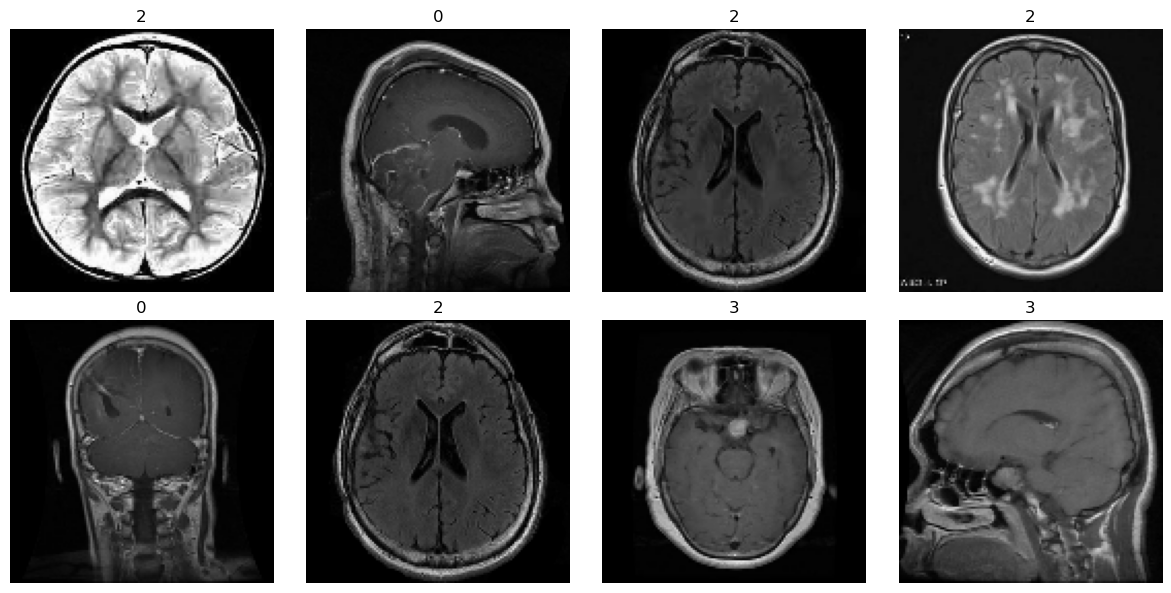

In [11]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

## If you want to apply data augmentation operations on the train dataset

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
                        
```


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__

In [12]:
# create a simple CNN model as baseline

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9

Epoch 1/10


2024-04-04 14:58:38.739040: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-04 14:58:39.291316: I external/local_xla/xla/service/service.cc:168] XLA service 0x71e5947f09e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-04 14:58:39.291349: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-04-04 14:58:39.297506: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712235519.376770  280132 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 [==============================] - 5s 19ms/step - loss: 0.7122 - accuracy: 0.7107 - val_loss: 0.6429 - val_accuracy: 0.7478
Epoch 2/10
143/143 [==============================] - 2s 13ms/step - loss: 0.4109 - accuracy: 0.8497 - val_loss: 0.3504 - val_accuracy: 0.8888
Epoch 3/10
143/143 [==============================] - 2s 13ms/step - loss: 0.2972 - accuracy: 0.8915 - val_loss: 0.2797 - val_accuracy: 0.9054
Epoch 4/10
143/143 [==============================] - 2s 13ms/step - loss: 0.1973 - accuracy: 0.9300 - val_loss: 0.2543 - val_accuracy: 0.9177
Epoch 5/10
143/143 [==============================] - 2s 13ms/step - loss: 0.1560 - accuracy: 0.9446 - val_loss: 0.2247 - val_accuracy: 0.9273
Epoch 6/10
143/143 [==============================] - 2s 13ms/step - loss: 0.1083 - accuracy: 0.9617 - val_loss: 0.3027 - val_accuracy: 0.9063
Epoch 7/10
143/143 [==============================] - 2s 13ms/step - loss: 0.0655 - accuracy: 0.9790 - val_loss: 0.2686 - val_accuracy: 0.9203
Epoch 8/10

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:00<00:03,  2.56it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:00<00:01,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:00<00:00,  7.66it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:00<00:00,  8.84it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:01<00:00,  9.49it/s]

1/1 [==============================] - 0s 251ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:01<00:00,  7.27it/s]

              precision    recall  f1-score   support

      glioma       0.88      0.96      0.92       300
  meningioma       0.95      0.80      0.87       306
     notumor       0.95      0.99      0.97       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



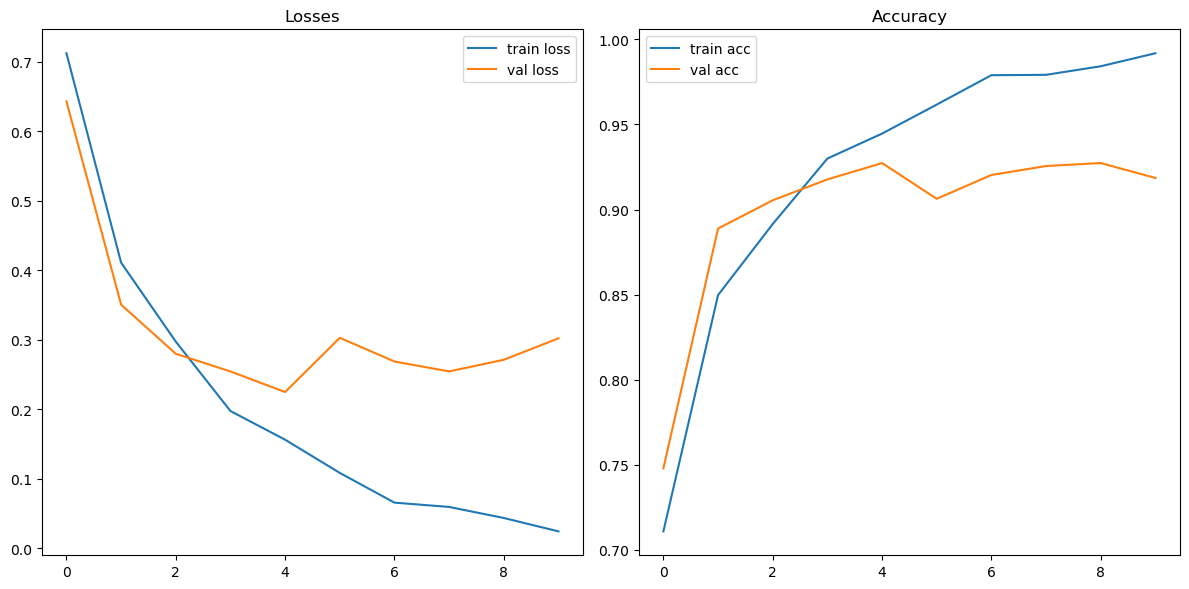

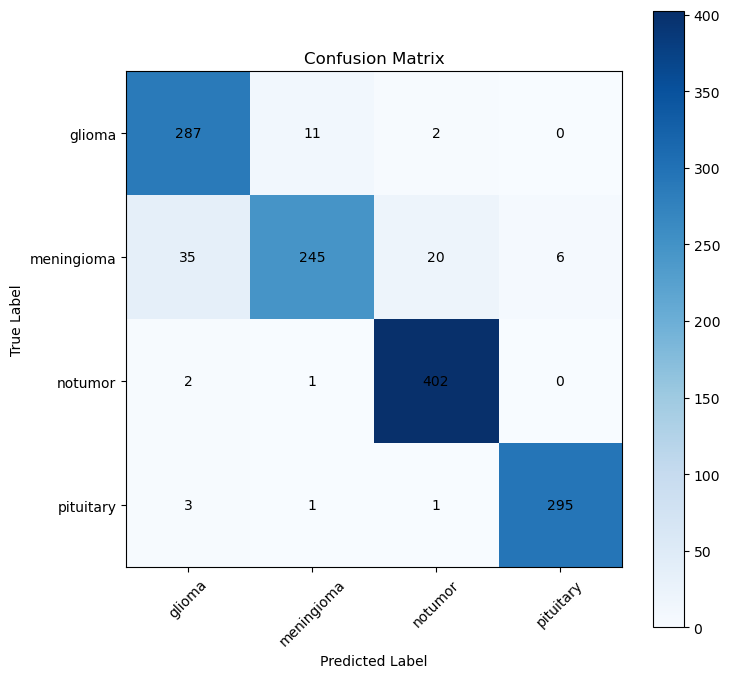

/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# train the model

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions = eval_model_on_test(model)

# get the predicted labels

predicted_labels = np.argmax(predictions, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('brain_tumor_classifier.h5')



In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 32)       

In [25]:
# add augmentation directly to the training set like:
train_ds, val_ds = prepare_train_and_val_datasets()
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))



Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


Epoch 1/10


143/143 [==============================] - 5s 13ms/step - loss: 0.8739 - accuracy: 0.6543 - val_loss: 0.6310 - val_accuracy: 0.7426
Epoch 2/10
143/143 [==============================] - 3s 13ms/step - loss: 0.5874 - accuracy: 0.7807 - val_loss: 0.4436 - val_accuracy: 0.8468
Epoch 3/10
143/143 [==============================] - 3s 13ms/step - loss: 0.4528 - accuracy: 0.8317 - val_loss: 0.3892 - val_accuracy: 0.8616
Epoch 4/10
143/143 [==============================] - 3s 12ms/step - loss: 0.3329 - accuracy: 0.8777 - val_loss: 0.4510 - val_accuracy: 0.8468
Epoch 5/10
143/143 [==============================] - 3s 12ms/step - loss: 0.2943 - accuracy: 0.8928 - val_loss: 0.3079 - val_accuracy: 0.9037
Epoch 6/10
143/143 [==============================] - 3s 12ms/step - loss: 0.2365 - accuracy: 0.9168 - val_loss: 0.2830 - val_accuracy: 0.9019
Epoch 7/10
143/143 [==============================] - 3s 13ms/step - loss: 0.1776 - accuracy: 0.9379 - val_loss: 0.3591 - val_accuracy: 0.8967
Epoch 8/10

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:00<00:03,  3.16it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:00<00:01,  6.71it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:00<00:00,  8.44it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:00<00:00,  9.36it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:01<00:00, 10.00it/s]

1/1 [==============================] - 0s 68ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:01<00:00,  8.87it/s]

              precision    recall  f1-score   support

      glioma       0.96      0.93      0.95       300
  meningioma       0.91      0.90      0.90       306
     notumor       0.96      0.99      0.97       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



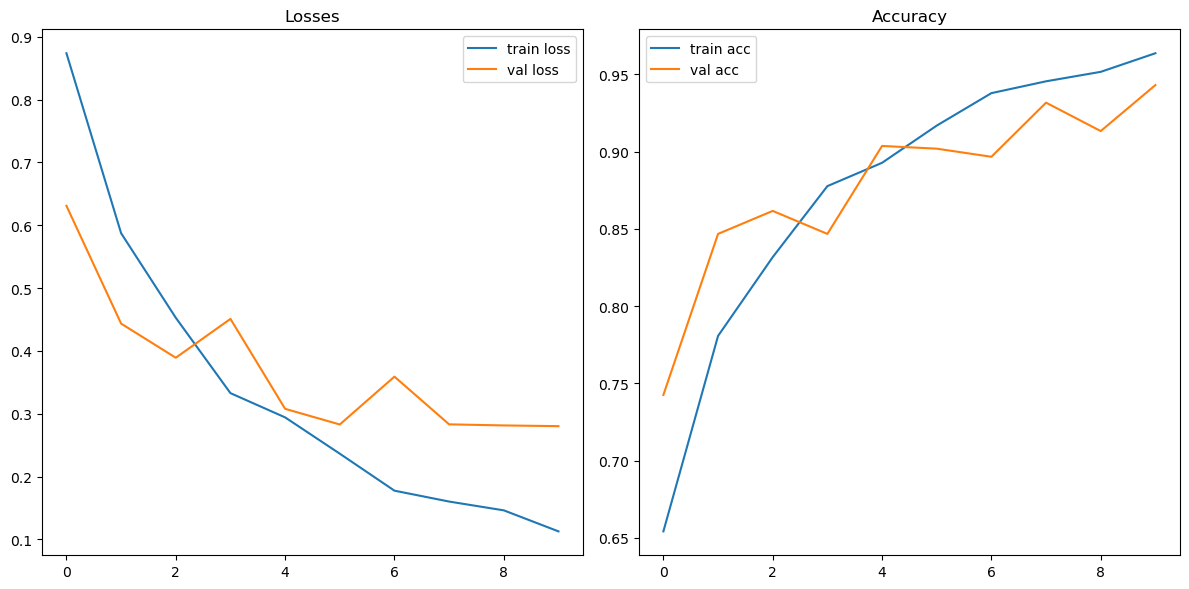

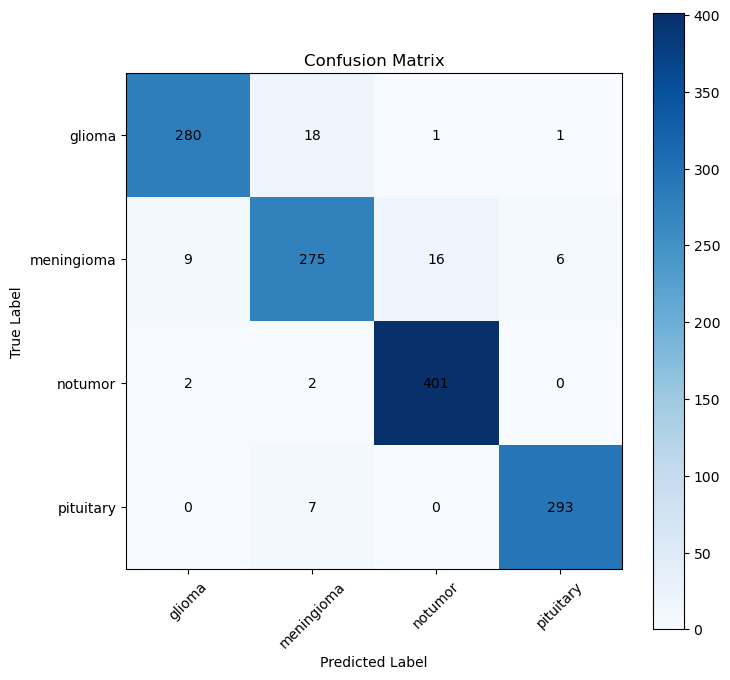

/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
# fit the same model with augmented data:



history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions = eval_model_on_test(model)

# get the predicted labels

predicted_labels = np.argmax(predictions, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('brain_tumor_classifier_aug_1.h5')

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 32)       

In [32]:
train_ds, val_ds = prepare_train_and_val_datasets()
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    #.map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                    .map(lambda image, label: (tf.image.random_brightness(image, max_delta=0.5), label))
                    .map(lambda image, label: (tf.image.random_flip_up_down(image), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


Epoch 1/20


143/143 [==============================] - 5s 13ms/step - loss: 0.7899 - accuracy: 0.6816 - val_loss: 0.6003 - val_accuracy: 0.7583
Epoch 2/20
143/143 [==============================] - 3s 13ms/step - loss: 0.5067 - accuracy: 0.8107 - val_loss: 0.5022 - val_accuracy: 0.8161
Epoch 3/20
143/143 [==============================] - 3s 13ms/step - loss: 0.4020 - accuracy: 0.8556 - val_loss: 0.4050 - val_accuracy: 0.8546
Epoch 4/20
143/143 [==============================] - 4s 13ms/step - loss: 0.3139 - accuracy: 0.8891 - val_loss: 0.3712 - val_accuracy: 0.8450
Epoch 5/20
143/143 [==============================] - 3s 12ms/step - loss: 0.2746 - accuracy: 0.9007 - val_loss: 0.2937 - val_accuracy: 0.8940
Epoch 6/20
143/143 [==============================] - 3s 12ms/step - loss: 0.2214 - accuracy: 0.9182 - val_loss: 0.3017 - val_accuracy: 0.8897
Epoch 7/20
143/143 [==============================] - 3s 12ms/step - loss: 0.2162 - accuracy: 0.9232 - val_loss: 0.2396 - val_accuracy: 0.9116
Epoch 8/20

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:00<00:03,  3.17it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:00<00:01,  5.23it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:00<00:01,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:00<00:00,  8.49it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:00<00:00,  8.86it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:01<00:00,  9.47it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:01<00:00,  9.41it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:01<00:00,  9.45it/s]

1/1 [==============================] - 0s 74ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:01<00:00,  6.64it/s]

              precision    recall  f1-score   support

      glioma       0.96      0.91      0.94       300
  meningioma       0.91      0.84      0.88       306
     notumor       0.93      0.99      0.96       405
   pituitary       0.96      1.00      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



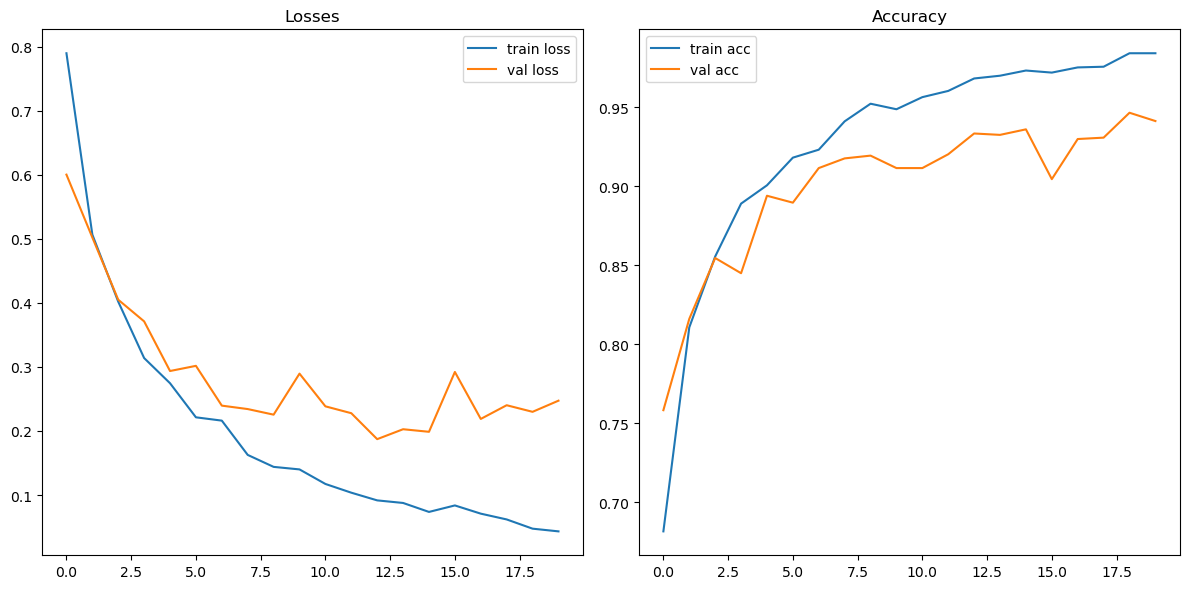

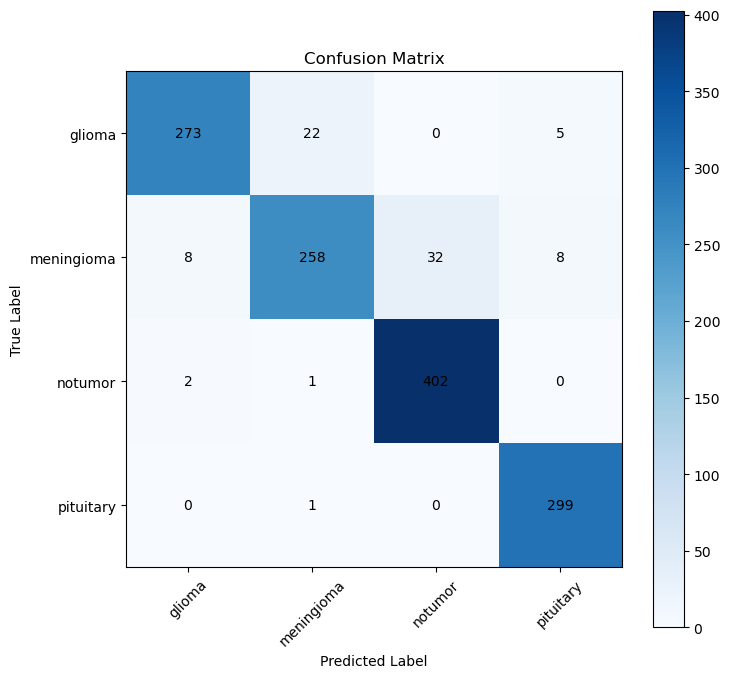

/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions = eval_model_on_test(model)

# get the predicted labels

predicted_labels = np.argmax(predictions, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('brain_tumor_classifier_aug_2.h5')

In [35]:
# now use early stopping to stop training when the validation loss stops decreasing

model = tf.keras.Sequential([

    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#use early stopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

train_ds, val_ds = prepare_train_and_val_datasets()

train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                    .map(lambda image, label: (tf.image.random_brightness(image, max_delta=0.5), label))
                    .map(lambda image, label: (tf.image.random_flip_up_down(image), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))




Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


Epoch 1/20


143/143 [==============================] - 5s 13ms/step - loss: 0.9041 - accuracy: 0.6389 - val_loss: 0.7125 - val_accuracy: 0.7180
Epoch 2/20
143/143 [==============================] - 4s 13ms/step - loss: 0.6818 - accuracy: 0.7361 - val_loss: 0.5673 - val_accuracy: 0.7881
Epoch 3/20
143/143 [==============================] - 4s 13ms/step - loss: 0.5523 - accuracy: 0.7858 - val_loss: 0.4848 - val_accuracy: 0.8082
Epoch 4/20
143/143 [==============================] - 4s 13ms/step - loss: 0.4705 - accuracy: 0.8219 - val_loss: 0.4435 - val_accuracy: 0.8503
Epoch 5/20
143/143 [==============================] - 4s 13ms/step - loss: 0.4347 - accuracy: 0.8269 - val_loss: 0.4374 - val_accuracy: 0.8441
Epoch 6/20
143/143 [==============================] - 4s 12ms/step - loss: 0.3602 - accuracy: 0.8608 - val_loss: 0.3393 - val_accuracy: 0.8581
Epoch 7/20
143/143 [==============================] - 4s 13ms/step - loss: 0.2989 - accuracy: 0.8867 - val_loss: 0.3346 - val_accuracy: 0.8940
Epoch 8/20

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:00<00:03,  3.20it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:00<00:01,  5.31it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:00<00:00,  7.81it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:00<00:00,  9.00it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:00<00:00,  9.17it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:01<00:00,  9.76it/s]

1/1 [==============================] - 0s 61ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:01<00:00,  8.52it/s]

              precision    recall  f1-score   support

      glioma       0.94      0.87      0.91       300
  meningioma       0.88      0.87      0.87       306
     notumor       0.95      0.99      0.97       405
   pituitary       0.96      0.99      0.97       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



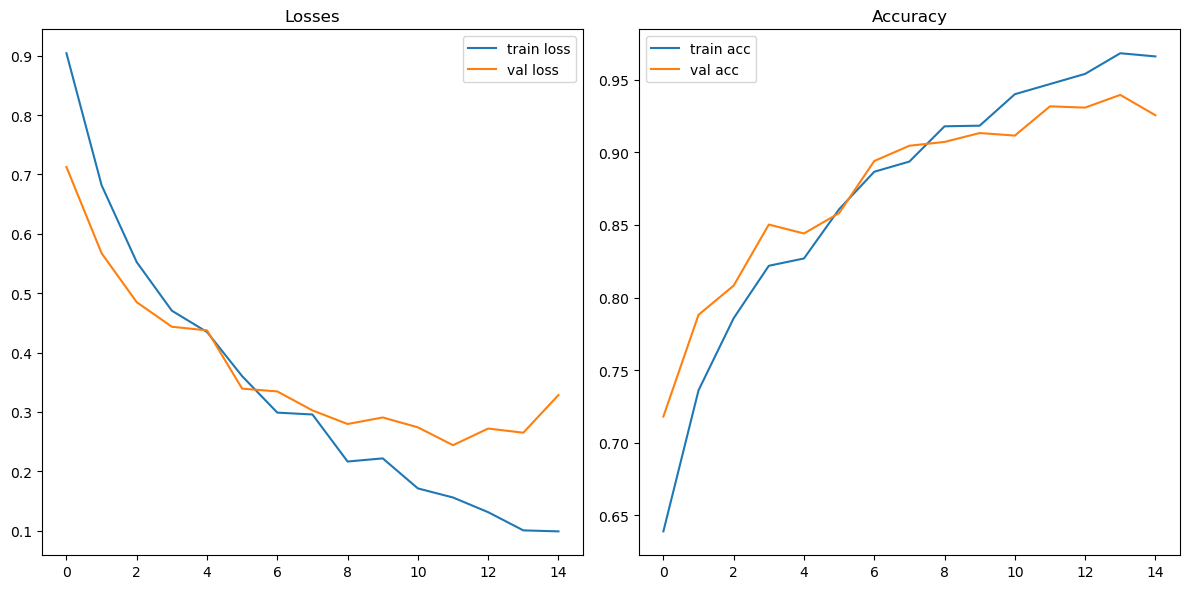

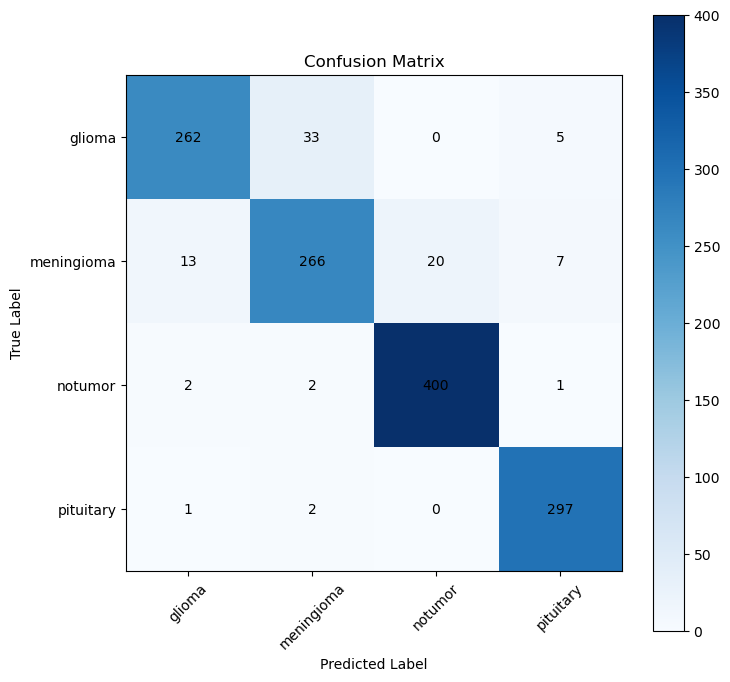

/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping]
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions = eval_model_on_test(model)

# get the predicted labels

predicted_labels = np.argmax(predictions, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('brain_tumor_classifier_aug_2_early_stop.h5')

In [67]:
# now create s simple u net model for the same task:

def unet_model():
    inputs = tf.keras.layers.Input(shape=IMG_SHAPE)

    conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D()(conv1)

    conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D()(conv2)

    conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D()(conv3)

    conv4 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D()(conv4)

    conv5 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.Conv2D(256, 2, activation='relu', padding='same')(
        tf.keras.layers.UpSampling2D()(conv5))
    merge6 = tf.keras.layers.concatenate([conv4, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(merge6)
    conv6 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv2D(128, 2, activation='relu', padding='same')(
        tf.keras.layers.UpSampling2D()(conv6))
    merge7 = tf.keras.layers.concatenate([conv3
                                            , up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge7)
    conv7 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.Conv2D(64, 2, activation='relu', padding='same')(
        tf.keras.layers.UpSampling2D()(conv7))
    merge8 = tf.keras.layers.concatenate([conv2, up8], axis=3)
    conv8 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge8)
    conv8 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = tf.keras.layers.Conv2D(32, 2, activation='relu', padding='same')(
        tf.keras.layers.UpSampling2D()(conv8))
    merge9 = tf.keras.layers.concatenate([conv1, up9], axis=3)
    conv9 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(merge9)
    conv9 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(conv9)

    conv10 = tf.keras.layers.Conv2D(4, 1, activation='softmax')(conv9)

    return tf.keras.Model(inputs=inputs, outputs=conv10)


model = unet_model()

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_89 (Conv2D)          (None, 128, 128, 32)         896       ['input_2[0][0]']             
                                                                                                  
 conv2d_90 (Conv2D)          (None, 128, 128, 32)         9248      ['conv2d_89[0][0]']           
                                                                                                  
 max_pooling2d_70 (MaxPooli  (None, 64, 64, 32)           0         ['conv2d_90[0][0]']           
 ng2D)                                                                                      

In [68]:
train_ds, val_ds = prepare_train_and_val_datasets()

train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                    .map(lambda image, label: (tf.image.random_brightness(image, max_delta=0.5), label))
                    .map(lambda image, label: (tf.image.random_flip_up_down(image), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))




Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [70]:
# train the model with the unet model

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)




Epoch 1/20


2024-04-04 17:47:14.019895: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: Graph execution error:

Detected at node Equal defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_277591/322785415.py", line 1, in <module>

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py", line 1155, in train_step

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py", line 1249, in compute_metrics

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 620, in update_state

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 723, in update_state

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/metrics/accuracy_metrics.py", line 459, in sparse_categorical_accuracy

  File "/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 969, in sparse_categorical_matches

required broadcastable shapes
	 [[{{node Equal}}]] [Op:__inference_train_function_237106]

In [ ]:
train_ds, val_ds = prepare_train_and_val_datasets()

train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                    .map(lambda image, label: (tf.image.random_brightness(image, max_delta=0.5), label))
                    .map(lambda image, label: (tf.image.random_flip_up_down(image), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))


In [71]:
# create a deep neural network with droputs and batch normalization

def dnn_model():
    inputs = tf.keras.layers.Input(shape=IMG_SHAPE)

    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

    x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(4)(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


model = dnn_model()

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_22 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 conv2d_112 (Conv2D)         (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_74 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0   

In [72]:
# train the model with the dnn model

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20


2024-04-04 17:48:57.368072: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 12s 42ms/step - loss: 2.2069 - accuracy: 0.6184 - val_loss: 8.4492 - val_accuracy: 0.2137
Epoch 2/20
143/143 [==============================] - 7s 37ms/step - loss: 0.7294 - accuracy: 0.7129 - val_loss: 9.3490 - val_accuracy: 0.4378
Epoch 3/20
143/143 [==============================] - 7s 37ms/step - loss: 0.6200 - accuracy: 0.7486 - val_loss: 6.4220 - val_accuracy: 0.3958
Epoch 4/20
143/143 [==============================] - 7s 37ms/step - loss: 0.5705 - accuracy: 0.7696 - val_loss: 0.8848 - val_accuracy: 0.7180
Epoch 5/20
143/143 [==============================] - 7s 37ms/step - loss: 0.5045 - accuracy: 0.7937 - val_loss: 0.6173 - val_accuracy: 0.8284
Epoch 6/20
143/143 [==============================] - 8s 37ms/step - loss: 0.4473 - accuracy: 0.8293 - val_loss: 0.8433 - val_accuracy: 0.6874
Epoch 7/20
143/143 [==============================] - 7s 37ms/step - loss: 0.4217 - accuracy: 0.8442 - val_loss: 0.6184 - val_accuracy: 0.7846
Epoch 8/2

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:00<00:03,  2.74it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:00<00:01,  4.64it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:00<00:01,  5.94it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:00<00:01,  6.32it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:00<00:00,  6.98it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:00<00:00,  7.32it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  7.59it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:01<00:00,  7.85it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:01<00:00,  8.17it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:01<00:00,  8.44it/s]

1/1 [==============================] - 0s 266ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:01<00:00,  6.29it/s]

              precision    recall  f1-score   support

      glioma       0.98      0.75      0.85       300
  meningioma       0.76      0.82      0.79       306
     notumor       0.91      0.97      0.94       405
   pituitary       0.93      0.99      0.96       300

    accuracy                           0.89      1311
   macro avg       0.89      0.88      0.88      1311
weighted avg       0.90      0.89      0.89      1311



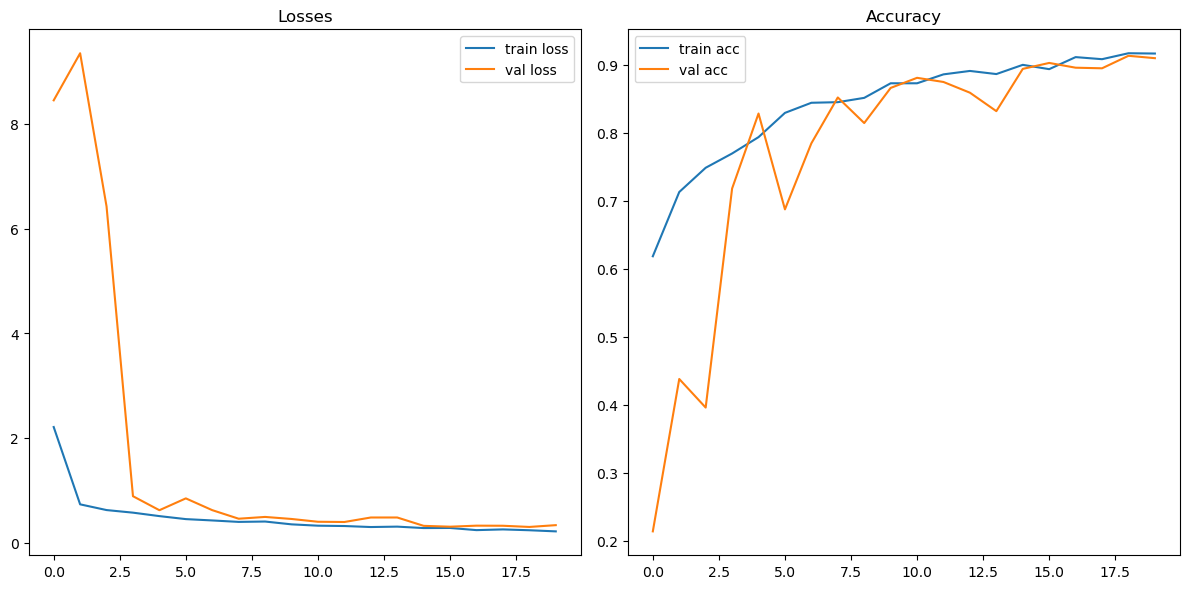

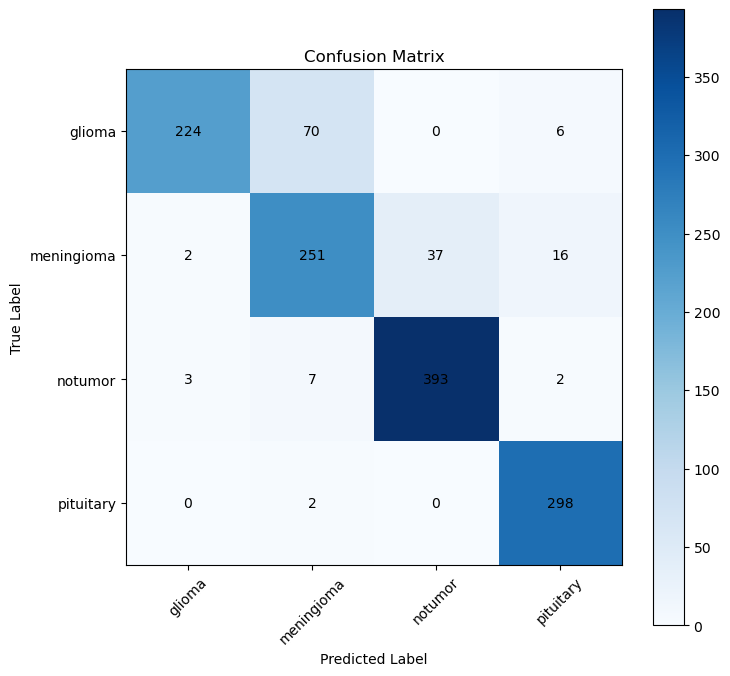

/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [73]:


# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions = eval_model_on_test(model)

# get the predicted labels

predicted_labels = np.argmax(predictions, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('brain_tumor_classifier_aug_2_early_stop.h5')

In [74]:
# now create a dnn without cnn layers, pure dnn with droput

def dnn_model():
    inputs = tf.keras.layers.Input(shape=IMG_SHAPE)

    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(4)(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


model = dnn_model()

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_23 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 flatten_23 (Flatten)        (None, 49152)             0         
                                                                 
 dense_46 (Dense)            (None, 128)               6291584   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_47 (Dense)            (None, 128)               16512     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0   

In [75]:
# train the model with the dnn model

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20
143/143 [==============================] - 4s 7ms/step - loss: 1.5239 - accuracy: 0.3317 - val_loss: 1.3047 - val_accuracy: 0.4282
Epoch 2/20
143/143 [==============================] - 3s 6ms/step - loss: 1.2927 - accuracy: 0.3597 - val_loss: 1.1567 - val_accuracy: 0.4510
Epoch 3/20
143/143 [==============================] - 3s 6ms/step - loss: 1.1972 - accuracy: 0.4383 - val_loss: 0.9298 - val_accuracy: 0.6436
Epoch 4/20
143/143 [==============================] - 3s 6ms/step - loss: 1.0991 - accuracy: 0.4961 - val_loss: 0.8612 - val_accuracy: 0.6629
Epoch 5/20
143/143 [==============================] - 3s 6ms/step - loss: 1.0555 - accuracy: 0.5295 - val_loss: 0.8085 - val_accuracy: 0.6541
Epoch 6/20
143/143 [==============================] - 3s 6ms/step - loss: 1.0347 - accuracy: 0.5455 - val_loss: 0.8959 - val_accuracy: 0.6278
Epoch 7/20
143/143 [==============================] - 3s 6ms/step - loss: 0.9821 - accuracy: 0.5556 - val_loss: 0.7724 - val_accuracy: 0.7023
Epoch 

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:00<00:03,  2.62it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:00<00:01,  4.58it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:00<00:01,  6.04it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:00<00:01,  6.71it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:00<00:00,  7.27it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:00<00:00,  7.85it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:01<00:00,  8.95it/s]

4/4 [==============================] - 0s 2ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:01<00:00,  9.66it/s]

1/1 [==============================] - 0s 75ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:01<00:00,  7.64it/s]

              precision    recall  f1-score   support

      glioma       0.47      0.98      0.63       300
  meningioma       0.32      0.04      0.06       306
     notumor       0.90      0.73      0.81       405
   pituitary       0.81      0.88      0.84       300

    accuracy                           0.66      1311
   macro avg       0.63      0.66      0.59      1311
weighted avg       0.65      0.66      0.60      1311



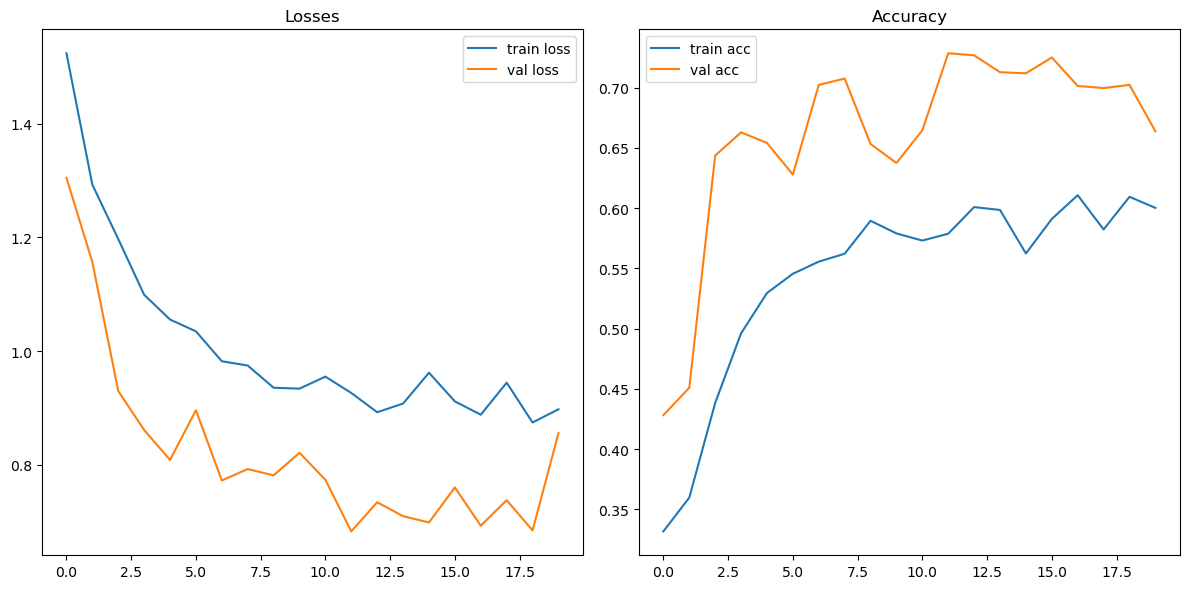

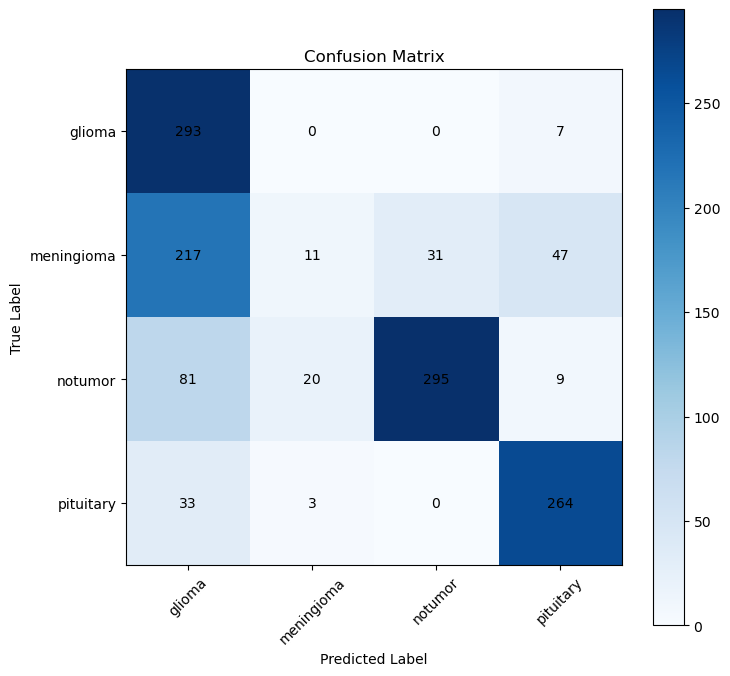

/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [76]:


# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions = eval_model_on_test(model)

# get the predicted labels

predicted_labels = np.argmax(predictions, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('brain_tumor_classifier_aug_2_early_stop.h5')

In [77]:
# now use a transfer learning model with a pre-trained model for the same task:

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(4)(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_8 (Dropout)         (None, 1280)              0         
                                                                 
 dense_51 (Dense)            (None, 4)                 5124      
                                                              

In [78]:
# train the model with the transfer learning model

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)



Epoch 1/20
143/143 [==============================] - 10s 33ms/step - loss: 1.1623 - accuracy: 0.5055 - val_loss: 0.8380 - val_accuracy: 0.6532
Epoch 2/20
143/143 [==============================] - 5s 18ms/step - loss: 0.8749 - accuracy: 0.6449 - val_loss: 0.7375 - val_accuracy: 0.6900
Epoch 3/20
143/143 [==============================] - 5s 18ms/step - loss: 0.7803 - accuracy: 0.6829 - val_loss: 0.6855 - val_accuracy: 0.7303
Epoch 4/20
143/143 [==============================] - 5s 18ms/step - loss: 0.7637 - accuracy: 0.6923 - val_loss: 0.6278 - val_accuracy: 0.7504
Epoch 5/20
143/143 [==============================] - 5s 18ms/step - loss: 0.7090 - accuracy: 0.7197 - val_loss: 0.6423 - val_accuracy: 0.7417
Epoch 6/20
143/143 [==============================] - 5s 18ms/step - loss: 0.6907 - accuracy: 0.7254 - val_loss: 0.6247 - val_accuracy: 0.7627
Epoch 7/20
143/143 [==============================] - 5s 18ms/step - loss: 0.6698 - accuracy: 0.7400 - val_loss: 0.5953 - val_accuracy: 0.764

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 1s 14ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:00<00:09,  1.01it/s]

4/4 [==============================] - 0s 15ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  2.03it/s]

4/4 [==============================] - 0s 15ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  3.01it/s]

4/4 [==============================] - 0s 14ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.90it/s]

4/4 [==============================] - 0s 15ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.52it/s]

4/4 [==============================] - 0s 14ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.04it/s]

4/4 [==============================] - 0s 14ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.63it/s]

4/4 [==============================] - 0s 14ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:01<00:00,  6.14it/s]

4/4 [==============================] - 0s 14ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.40it/s]

4/4 [==============================] - 0s 13ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.73it/s]

1/1 [==============================] - 1s 1s/step


Predicting on Test Data: 100%|██████████| 11/11 [00:03<00:00,  2.99it/s]

              precision    recall  f1-score   support

      glioma       0.81      0.49      0.61       300
  meningioma       0.52      0.52      0.52       306
     notumor       0.83      0.96      0.89       405
   pituitary       0.77      0.92      0.84       300

    accuracy                           0.74      1311
   macro avg       0.73      0.72      0.71      1311
weighted avg       0.74      0.74      0.73      1311



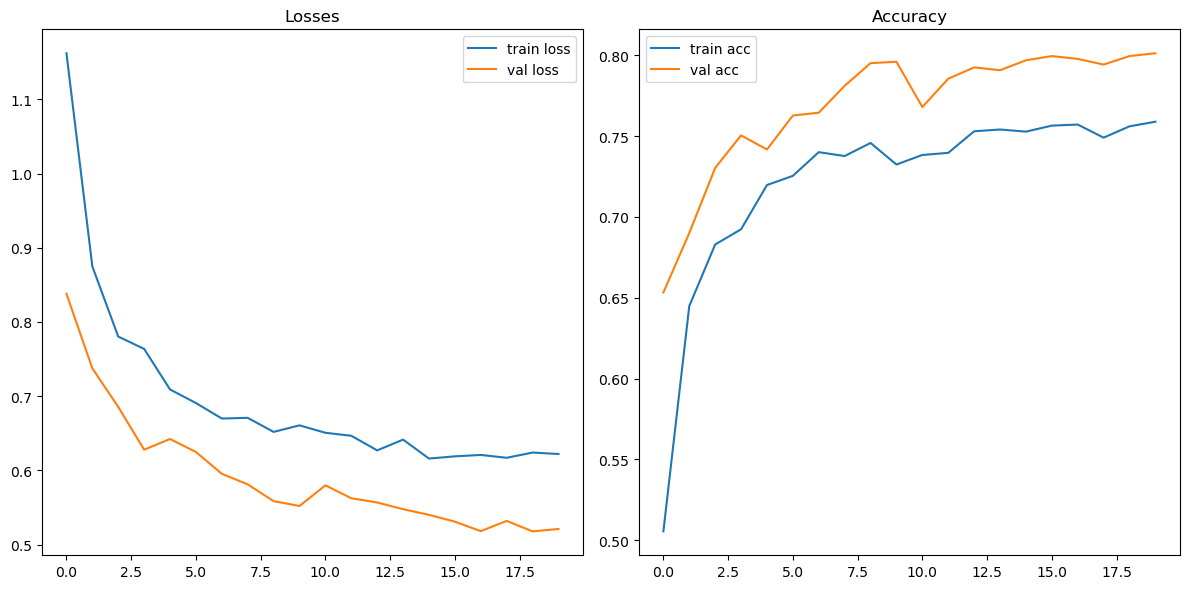

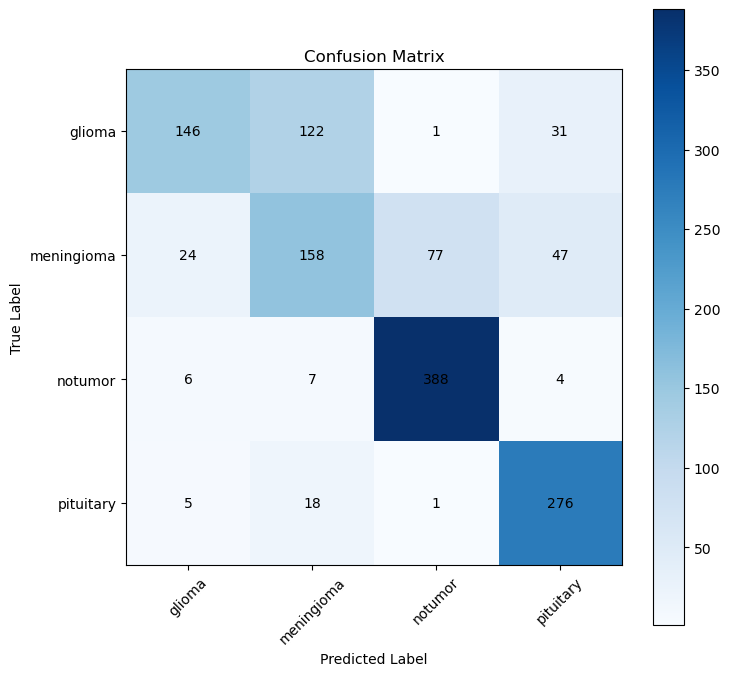

/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [79]:


# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions = eval_model_on_test(model)

# get the predicted labels

predicted_labels = np.argmax(predictions, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('brain_tumor_classifier_aug_2_early_stop.h5')